## Here we are going to transform real tennis match data into the same format as our mock data.
## The detailed point-by-point data come from Jeff Sackmanns' Match Charting project, so I encourage anyone interested to check out that project, and even contribute. https://github.com/JeffSackmann/tennis_MatchChartingProject . A data science dive this one would not be possible without these data, which do not exist (as far as I can tell) *anywhere else* on the internet. I will be using the file, tennis_MatchChartingProject/charting-m-points.csv ,from that repo.

This work is based on crowdsourced shot-by-shot professional tennis data by The Tennis Abstract Match Charting Project, and is licensed under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License.
Based on a work at https://github.com/JeffSackmann/tennis_MatchChartingProject



In [9]:
filepath = '/home/gmbrandt/Documents/misc_codes/tennis_MatchChartingProject/charting-m-points.csv'

## These data are extremely rich. The columns 1st and 2nd contain how the entire point played out. Because we are just interested in serves, we want to transform column 1 and 2 into one single bite: a 0 or 1 if the first serve went in. 
### We need to do the following things:
1. serve direction is given by: (4 = wide, 5 = body, 6 = down the t; http://www.tennisabstract.com/blog/2015/09/23/the-match-charting-project-quick-start-guide/ ), and the following codes: (n = net, w = wide, d = deep, x = wide and deep), indicate the type of error. So we are interested in situations where the point code is only 2 entries long: things like 4n, 5n, 5w, 6x etc...
2. We need to identify uniquely, for each service point, who is serving. Then we simply need to group by that column later on and then save the full sequence of that persons serves.
3. We are only going to use match data post 2015, just to keep the number of years to a minimum. Players change over time, but many will be roughly consistent over a 2-3 year period (four years is pushing it). If we go longer than that, we will have to split players into their different eras, because e.g., Federer from 2005 is not identical to Federer in 2020. 

In [166]:
import pandas as pd
# match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,
colnames = ['match_id', 'Pt', 'Pts', 'Svr','Ret','Serving','1st','2nd']
t = pd.read_csv(filepath, usecols=colnames)

In [193]:
from astropy.table import Table 
# switch to astropy tables because of the convenient grouping functions.
tt = Table(t.to_numpy(), names=colnames, dtype=[str, str, str, int, int, str, str, str])

In [194]:
# scrub entries where the server is listed as nan -- these were likely improperly tabulated.
tt = tt[tt['Serving'] != 'nan']

In [197]:
tt['date'] = '20220213'
for i in tt:
    split = i['match_id'].split('-M-')
    i['date'] = split[0]

In [198]:
# sort by date.
tt.sort('date')

In [199]:
from astropy.time import Time
# remove everything before 2015.
tt = tt[Time([i[:4] for i in tt['date']], format='decimalyear') > Time(2015, format='decimalyear')]

In [200]:
print(np.count_nonzero(['federer' in i['match_id'].lower() for i in tt])//2, 'is about how many serves we expect from Federer in this dataset. This is a sanity check for our grouping later.')
print(np.count_nonzero(['djokovic' in i['match_id'].lower() for i in tt])//2, 'is about how many serves we expect from Djokovic in this dataset. This is a sanity check for our grouping later.')

10671 is about how many serves we expect from Federer in this dataset. This is a sanity check for our grouping later.
9188 is about how many serves we expect from Djokovic in this dataset. This is a sanity check for our grouping later.


### now for the only difficult bit. We need to uniquely identify each server in this data set. This is slightly non trivial because the full name of both players is in match_id and their initials are in 'Serving' . But the match_id is not a standard format string, and the initials are of course not unique player to player.

In [ ]:
# we may just have to do this manually for a few of the top players. Something like if 'djokovic' in match ID and 'ND' in Serving
# and same for RF and the other top players.

tt['svr_fullid'] = ' '*100
for i in tt:
    if i['Svr'] == 1:
        i['svr_fullid'] = i['Serving'] + '_' + split[1].split('_')[0].lstrip('-').rstrip('-')
    if i['Svr'] == 2:
        i['svr_fullid'] = i['Serving'] + '_' + split[1].split('_')[-1].lstrip('-').rstrip('-')

## Now that that is done, we just need to identify first serve faults.

In [177]:
tt['first_serve_in'] = 1
fault_codes = ['n', 'w', 'd', 'x']
for i in tt:
    pt_string = i['1st']
    pt_string = pt_string.lstrip(' ').rstrip(' ') # strip any leading or trailing zeros.
    if len(pt_string) == 2:
        if pt_string[1] in fault_codes:
            i['first_serve_in'] = 0


In [178]:
print(len(set(tt['svr_fullid'])))
print(len(set(tt['Serving'])))

1362
261


In [201]:
print(len(tt), ' total serves on record')

243167  total serves on record


In [180]:
tt = tt.group_by('svr_fullid')

## Ok, now as a check, we want to see what kind of statistics per server we have achieved. Remember we want at least a few players with 10,000 to 20,000 serves on record. Ideally about 50. Players with less than a few thousand serves on record can be scrubbed.

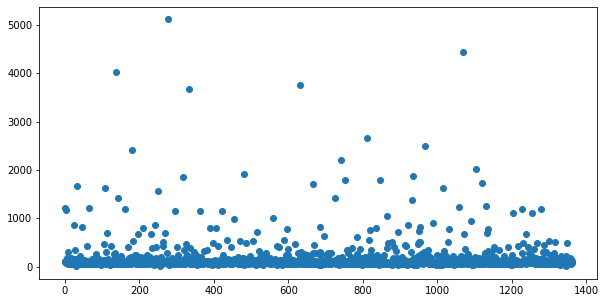

In [181]:
import matplotlib.pyplot as plt
import numpy as np

serves_per_group = []
for i in range(len(tt.groups)):
    serves_per_group.append(len(tt.groups[i]))
serves_per_group = np.array(serves_per_group)

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(serves_per_group)), serves_per_group)
plt.show()

## Great! We have a handful of players with > 10,000 serves on record. Let's restrict to those with > 2000, and proceed.

In [182]:
tt_interest_only = tt.groups[np.array(serves_per_group) > 2000]

In [183]:
print(set(tt_interest_only['svr_fullid']))
print('The players we are looking at are:')

{'MF_Fucsovics', 'RN_Nadal', 'JS_Sinner', 'ND_Australian', 'BP_Paire', 'BC_Coric', 'ND_Djokovic', 'DSS_Schwartzman', 'NB_Basilashvili', 'GM_Monfils', 'AR_Rublev', 'KN_Nishikori', 'FF_Fognini', 'DG_Goffin', 'AB_Bedene', 'AM_Murray', 'DE_Evans', 'RH_Haase', 'ADM_Minaur', 'RN_Australian', 'ST_Tsitsipas', 'RG_Gasquet', 'RF_Federer', 'DM_Medvedev', 'AB_Bublik', 'BVD_Zandschulp', 'FAA_Aliassime', 'ADF_Fokina', 'PCB_Busta', 'TG_Griekspoor', 'SW_Wawrinka', 'GD_Dimitrov', 'NK_Kyrgios', 'PK_Kohlschreiber', 'ST_Australian', 'MB_Berrettini', 'MK_Kecmanovic', 'AZ_Zverev', 'DS_Shapovalov', 'JMD_Potro', 'JT_Tipsarevic', 'DT_Thiem', 'KMM_Maamoun', 'AK_Karatsev', 'RF_Australian', 'IK_Karlovic', 'KK_Khachanov', 'FT_Tiafoe', 'ND_US'}
